# Q5: Analysis (20 points)
By now you should know how to train networks from scratch or using from pre-trained models. You should also understand the relative performance in either scenarios. Needless to say, the performance of these models is stronger than previous non-deep architectures used until 2012. However, final performance is not the only metric we care about. It is important to get some intuition of what these models are really learning. Lets try some standard techniques.


**FEEL FREE TO WRITE UTIL CODE IN ANOTHER FILE AND IMPORT IN THIS NOTEBOOK FOR EASE OF READABILITY**

## 5.1 Nearest Neighbors (7 pts)
Pick 3 images from PASCAL test set from different classes, and compute 4 nearest neighbors of those images over the test set. You should use and compare the following feature representations for the nearest neighbors:
1. fc7 features from the ResNet (finetuned from ImageNet)
2. pool5 features from the CaffeNet (trained from scratch)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import matplotlib.pyplot as plt
%matplotlib inline

import trainer
from utils import ARGS, get_data_loader, eval_dataset_map
from simple_cnn import SimpleCNN
from voc_dataset import VOCDataset
from tqdm import tqdm
import numpy as np
from models import PretrainedResNet, CaffeNet

In [2]:
# load images, calculate nearest neighbors, and plot
args = ARGS(batch_size=32, test_batch_size=32, epochs=50, val_every=250, lr=1e-4, size=227, save_freq=10)
test_loader = get_data_loader('voc', train=False, batch_size=args.test_batch_size, split='test', args=args)

In [3]:
# only needs to be run once for each model

resnet = PretrainedResNet()
resnet.load_state_dict(torch.load('/home/aaronhua/vlr/hw1/runs/q4/model_09.pt'))
resnet.cuda()
resnet.eval()
all_features = [None] * len(test_loader)
with torch.no_grad():
    for idx, batch in enumerate(tqdm(test_loader)):
        image, label, wgt = batch
        res_features = resnet.backbone(image.cuda()).squeeze().cpu().numpy()
        all_features[idx] = res_features
concat_features = np.concatenate(all_features, axis=0)
with open('resnet_features.np', 'wb') as f:
    np.save(f, concat_features)
    

100%|██████████| 155/155 [00:10<00:00, 14.19it/s]


In [4]:
cafnet = CaffeNet()
cafnet.load_state_dict(torch.load('/home/aaronhua/vlr/hw1/runs/q2/model_49.pt'))
cafnet.cuda()
cafnet.eval()
all_features = [None] * len(test_loader)
with torch.no_grad():
    for idx, batch in enumerate(tqdm(test_loader)):
        image, label, wgt = batch
        caf_features = cafnet.backbone(image.cuda()).squeeze().cpu().numpy()
        all_features[idx] = caf_features
concat_features = np.concatenate(all_features, axis=0)
with open('cafnet_features.np', 'wb') as f:
    np.save(f, concat_features)
    

100%|██████████| 155/155 [00:09<00:00, 15.89it/s]


In [5]:
with open('resnet_features.np', 'rb') as f:
    resnet_features = np.load(f)
with open('cafnet_features.np', 'rb') as f:
    cafnet_features = np.load(f)

In [6]:
# get gt class names for each sample
def print_names():
    names = VOCDataset.CLASS_NAMES
    for batch_idx, batch in enumerate(test_loader):
        images, labels, wgts = batch
        for i in range(len(images)):
            idxs = np.where(labels[i].numpy() != 0)[0]
            gt_names = [names[j] for j in idxs]
            print(i, gt_names)
        break
        
print_names()
# 1 train, 5 chair, 11 dog     
soi = [1, 5, 11]

def get_image(dataset, index, show=False):
    image, label, wgt = dataset[index]
    image = image.numpy()
    c, h, w = image.shape
    
    # normalize to 0,1
    min = np.amin(image.reshape(c, h*w), axis=1)
    min = np.expand_dims(min, axis=(1,2))
    max = np.amax(image.reshape(c,h*w), axis=1)
    max = np.expand_dims(max, axis=(1,2))
    image = (image - min) / (max - min)
    image = image.transpose(1,2,0) # RGB space
    
    if show:
        plt.imshow(image)
    return image

def get_neighbors(index, concat_features):
    features = concat_features[index]
    distance = np.linalg.norm(concat_features - features, axis=1)
    sorted_idxs = np.argsort(distance)
    return sorted_idxs


dataset = test_loader.dataset

0 ['dog', 'person']
1 ['train']
2 ['chair', 'sofa']
3 ['car']
4 ['chair', 'diningtable', 'pottedplant']
5 ['chair']
6 ['horse', 'person']
7 ['cat']
8 ['cow']
9 ['bus', 'car', 'person']
10 ['bicycle']
11 ['dog']
12 ['horse', 'person']
13 ['cow', 'person']
14 ['person']
15 ['cat']
16 ['dog']
17 ['train']
18 ['dog']
19 ['bicycle', 'motorbike', 'person']
20 ['bird']
21 ['person']
22 ['tvmonitor']
23 ['cat']
24 ['cat']
25 ['bus']
26 ['motorbike', 'person']
27 ['horse']
28 ['bird']
29 ['motorbike', 'person']
30 ['chair', 'person', 'tvmonitor']
31 ['sheep']


ResNet nearest neighbors


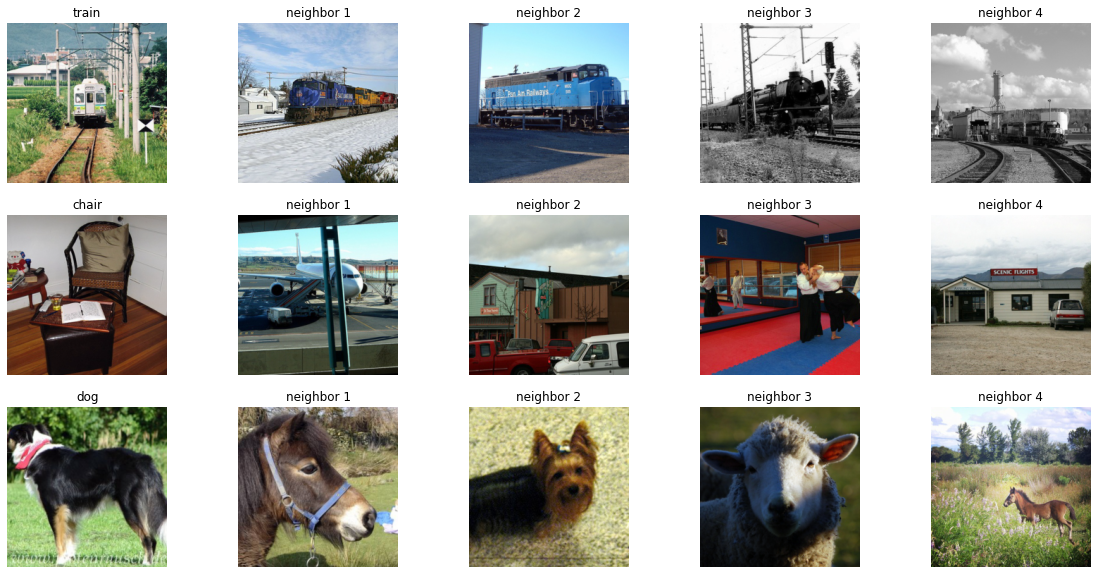

In [7]:
# RESNET NEAREST NEIGHBORS
res_ngbrs = [get_neighbors(i, resnet_features) for i in soi]
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(20,10))
titles = ['train', 'chair', 'dog']
for row, i in enumerate(soi):
    title_list = [titles[row]] + [f'neighbor {i+1}' for i in range(4)]
    for col, ngbr in enumerate(res_ngbrs[row][:5]):
        ax[row,col].imshow(get_image(dataset, ngbr))
        ax[row,col].set_title(title_list[col])
        ax[row,col].axis('off')
print('ResNet nearest neighbors')

CaffeNet nearest neighbors


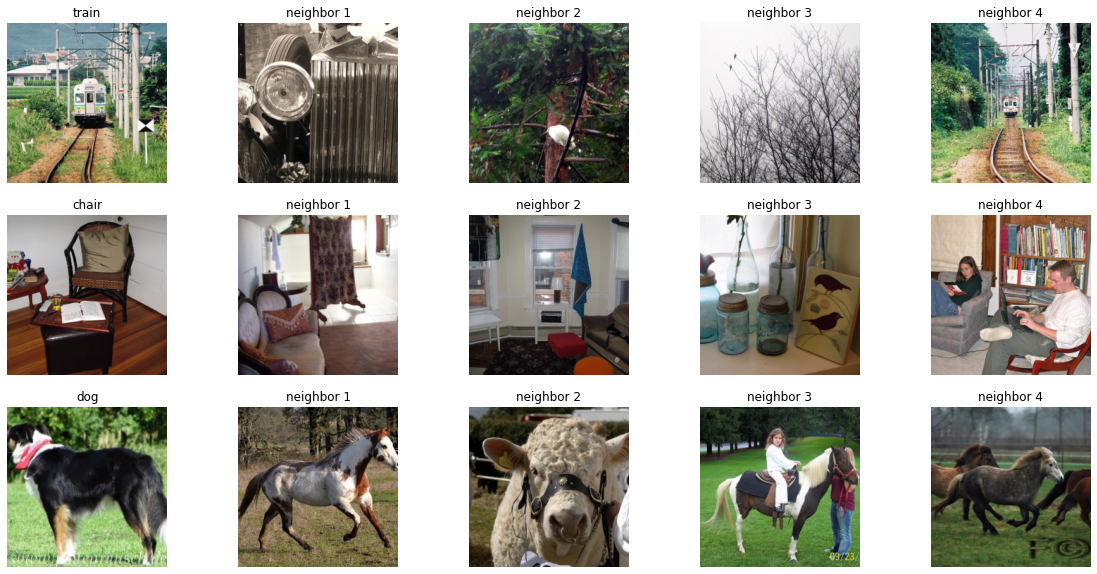

In [8]:
# CAFFENET NEAREST NEIGHBORS
caf_ngbrs = [get_neighbors(i, cafnet_features) for i in soi]
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(20,10))
titles = ['train', 'chair', 'dog']
for row, i in enumerate(soi):
    title_list = [titles[row]] + [f'neighbor {i+1}' for i in range(4)]
    for col, ngbr in enumerate(caf_ngbrs[row][:5]):
        ax[row,col].imshow(get_image(dataset, ngbr))
        ax[row,col].set_title(title_list[col])
        ax[row,col].axis('off')
print('CaffeNet nearest neighbors')

## 5.2 t-SNE visualization of intermediate features (7pts)
We can also visualize how the feature representations specialize for different classes. Take 1000 random images from the test set of PASCAL, and extract caffenet (scratch) fc7 features from those images. Compute a 2D t-SNE projection of the features, and plot them with each feature color coded by the GT class of the corresponding image. If multiple objects are active in that image, compute the color as the ”mean” color of the different classes active in that image. Legend the graph with the colors for each object class.

In [9]:
cafnet = CaffeNet()
cafnet.load_state_dict(torch.load('/home/aaronhua/vlr/hw1/runs/q2/model_49.pt'))
cafnet.cuda()
cafnet.eval()

# get caffenet fc7 features and voc test labels
all_features = [None] * len(test_loader)
all_labels = [None] * len(test_loader)
with torch.no_grad():
    for idx, batch in enumerate(tqdm(test_loader)):
        image, label, wgt = batch
        all_labels[idx] = label
        tsne_features = cafnet.tsne_features(image.cuda()).squeeze().cpu().numpy()
        all_features[idx] = tsne_features
        
# concat across batches and cache for later use
concat_features = np.concatenate(all_features, axis=0)
with open('tsne_features.np', 'wb') as f:
    np.save(f, concat_features)  
concat_labels = np.concatenate(all_labels, axis=0)
with open('test_labels.np', 'wb') as f:
    np.save(f, concat_labels)  

100%|██████████| 155/155 [00:10<00:00, 14.85it/s]


In [10]:
# get tsne features
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
with open('tsne_features.np', 'rb') as f:
    features = np.load(f)
y = tsne.fit_transform(features)
with open('fitted_features.np', 'wb') as f:
    np.save(f, y)

/home/aaronhua/anaconda3/envs/vlr/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/aaronhua/anaconda3/envs/vlr/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


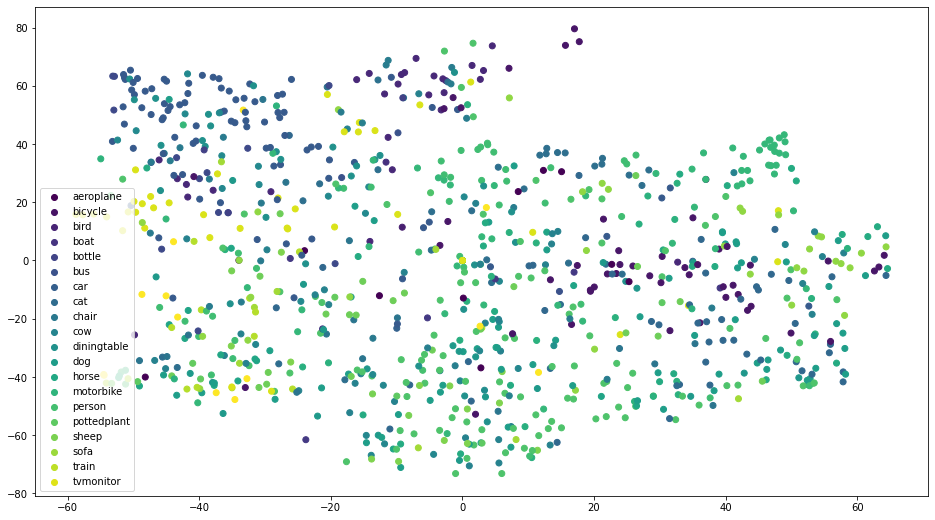

In [11]:
# make tSNE projection plot w/colormaps
with open('fitted_features.np', 'rb') as f:
    features = np.load(f)
with open('test_labels.np', 'rb') as f:
    labels = np.load(f)

# get normalized labels    
n, c = labels.shape
indices = np.repeat([np.arange(c)], n, axis=0)
masked_labels = np.multiply(labels, indices)
mean_labels = np.zeros(n)
for i, mask in enumerate(masked_labels):
    mean_labels[i] = np.mean(np.nonzero(mask))
norm_labels = mean_labels / 20

# plot first 1000
x,y = features.T
cmap = plt.cm.viridis
plt.scatter(x[:1000],y[:1000],c=norm_labels[:1000],cmap=cmap)

# legend hack
names = VOCDataset.CLASS_NAMES
for i in range(20):
    plt.scatter(0, 0, color=cmap(i/20), label=names[i])
plt.legend()
    
fig = plt.gcf()
fig.set_size_inches(16, 9)

## 5.3 Are some classes harder? (6pts)
Show the per-class performance of your caffenet (scratch) and ResNet (finetuned) models. Try to explain, by observing examples from the dataset, why some classes are harder or easier than the others (consider the easiest and hardest class). Do some classes see large gains due to pre-training? Can you explain why that might happen?

**YOUR ANSWER HERE**

The two code cells below respectively print out the per-class average precision of CaffeNet and ResNet. One observation is that there were some classes that were easier to recognize for both networks (e.g. people, airplanes, horses, cars) and others were harder for both (bottle, potted plant). ResNet pretraining was particularly effective for improving detection of dogs, birds, cats, and other living animals suggesting that unnaturally formed objects (e.g. dining tables, chairs) may be fundamentally hard to detect than objects with a more natural shape.

In [12]:
cafnet = CaffeNet()
cafnet.load_state_dict(torch.load('/home/aaronhua/vlr/hw1/runs/q2/model_49.pt'))
cafnet.cuda()
cafnet.eval()
ap, map = eval_dataset_map(cafnet, 'cuda', test_loader)
sap = [(i, ap[i]) for i in range(len(ap))]
sap = sorted(sap, key=lambda x:x[1])
print('CaffeNet per-class AP')
for s, elem in sap:
    print(f'{names[s]}: {elem:.2f}')

CaffeNet per-class AP
bottle: 0.16
pottedplant: 0.22
cow: 0.24
sheep: 0.33
dog: 0.34
cat: 0.36
bus: 0.36
diningtable: 0.36
bird: 0.37
sofa: 0.39
tvmonitor: 0.44
chair: 0.45
bicycle: 0.47
boat: 0.52
motorbike: 0.56
train: 0.61
aeroplane: 0.66
horse: 0.70
car: 0.70
person: 0.81


In [13]:
resnet = PretrainedResNet()
resnet.load_state_dict(torch.load('/home/aaronhua/vlr/hw1/runs/q4/model_09.pt'))
resnet.cuda()
resnet.eval()
ap, map = eval_dataset_map(resnet, 'cuda', test_loader)
sap = [(i, ap[i]) for i in range(len(ap))]
sap = sorted(sap, key=lambda x:x[1])
print('CaffeNet per-class AP')
for s, elem in sap:
    print(f'{names[s]}: {elem:.2f}')

CaffeNet per-class AP
bottle: 0.30
pottedplant: 0.42
diningtable: 0.49
sofa: 0.55
chair: 0.55
motorbike: 0.57
tvmonitor: 0.59
bus: 0.63
cow: 0.64
bicycle: 0.69
dog: 0.72
sheep: 0.72
boat: 0.73
cat: 0.76
train: 0.79
bird: 0.80
car: 0.82
aeroplane: 0.84
horse: 0.84
person: 0.90
